# Exploratory data analysis

Some exploration into the cleaned datasets `data/clean_data.csv`. It contains all of the flights minus the canceled ones, or ones with missing data in key columns, and only for the top 6 busiest airports in the US, and top 10 carriers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# plt.style.use("default")
plt.style.use("seaborn-v0_8-talk")
# plt.style.use("ggplot")
# plt.style.use("fivethirtyeight")
# plt.style.use("seaborn-v0_8-muted")

import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "mathtext.default": "regular",
    "xtick.direction" : "in",
    "ytick.direction" : "in",
    "xtick.top" : True,
    "ytick.right" : True,
    "axes.unicode_minus" : True
})

## Selection of airports

Before loading in the clean dataset, note that we have only kept the top 20 airports in the US (in terms of number of flights). We show why here.

In [2]:
ap_stats = pd.read_csv("../data/airport_stats.csv")
ap_stats.head()

,Unnamed: 0,ID,Name,N_from,N_from_2023,N_to,N_to_2023,delay_frac_from,delay_frac_from_2023,delay_frac_to,delay_frac_to_2023
0,16,10397,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",3581462,220762,3578947,220591,0.175835,0.236232,0.143543,0.196858
1,205,13930,"Chicago, IL: Chicago O'Hare International",2761293,169754,2756136,169514,0.222214,0.216189,0.186888,0.194114
2,78,11298,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter...",2467764,183321,2464525,183234,0.213326,0.255301,0.174559,0.217809
3,77,11292,"Denver, CO: Denver International",2267422,186030,2264944,185810,0.224249,0.297576,0.181147,0.230467
4,152,12892,"Los Angeles, CA: Los Angeles International",2048954,128293,2047834,128205,0.190791,0.204033,0.183590,0.218743


Plot fraction of delayed flights for every airport, according to the number of flights from that airport

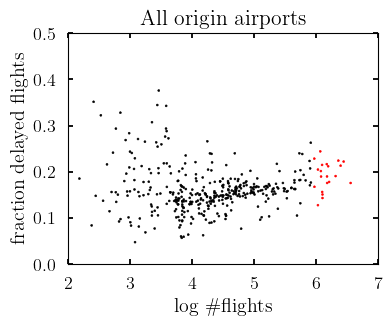

In [3]:
fig=plt.figure(figsize=(4,3))
plt.xlabel(r"log \#flights")
plt.ylabel(r"fraction delayed flights")

x = ap_stats.loc[ap_stats['N_from']>100]
plt.title("All origin airports")
colors = ['r' if i<21 else 'k' for i in range(len(x))]
plt.scatter(np.log10(x['N_from']), x['delay_frac_from'], marker='.', s=8, c=colors)
plt.xlim([2,7])
plt.ylim([0,0.5])
fig.savefig("plots/all_airports_delays.png",bbox_inches='tight',dpi=500)
plt.show()

The outliers (large and small delays) are for small airports! This would likely make the performance of the ML model worse, for not much benefit, since most flights will go from/to the biggest airports. We decided to keep only the red points, which are the top 20 biggest airports.

Which fraction of flights does that represent?

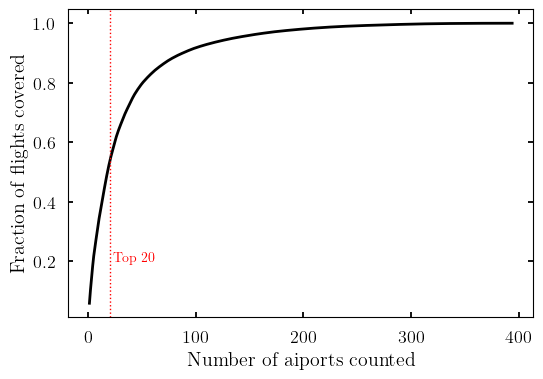

In [4]:
N_tot = ap_stats['N_from'].sum()
CDF=[0]
for i in range(len(ap_stats)):
    CDF.append(CDF[-1] + ap_stats.iloc[i]['N_from']/N_tot)
    
fig = plt.figure(figsize=(6,4))
plt.plot(np.arange(1,len(ap_stats)+1), CDF[1:], 'k-', lw=2)
plt.xlabel("Number of aiports counted")
plt.ylabel("Fraction of flights covered")
plt.text(23,0.2,"Top 20",ha='left',color='r')
plt.axvline(20,color='r',ls=':',lw=1)
fig.savefig("plots/N_flights_airports_CDF.png",bbox_inches='tight',dpi=500)
plt.show()

We get over half of all flights with the top 20 airports. But we also want to consider the destination. Considering only the network of flights to **and** from the top 20 airports, we cover 20% of all flights.

## EDA on clean data

`clean_data.csv` contains only top 20 airports as origin and destination.

In [5]:
df = pd.read_csv("../data/clean_data.csv", parse_dates=[1])
df.info()

# Create delay column
delay_thresh=15.
df = df.assign(DELAY_TF=pd.Series(df['DEP_DELAY']>delay_thresh).values.astype(int))

# a couple (literally 2) 2011 flights have slipped in during the cleaning due to departing late (they were supposed to depart in 2011, but left after midnight on jan 1st)
df = df[~df["FL_DATE"].dt.year.isin([2011])] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13764723 entries, 0 to 13764722
Data columns (total 14 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Unnamed: 0           int64         
 1   FL_DATE              datetime64[ns]
 2   OP_UNIQUE_CARRIER    object        
 3   ORIGIN_AIRPORT_ID    int64         
 4   DEST_AIRPORT_ID      int64         
 5   DEP_DELAY            float64       
 6   AIR_TIME             float64       
 7   CARRIER_DELAY        float64       
 8   WEATHER_DELAY        float64       
 9   NAS_DELAY            float64       
 10  SECURITY_DELAY       float64       
 11  LATE_AIRCRAFT_DELAY  float64       
 12  FRAC_YEAR            float64       
 13  FRAC_DAY             float64       
dtypes: datetime64[ns](1), float64(9), int64(3), object(1)
memory usage: 1.4+ GB


In [6]:
df.head()
# df.tail()

,Unnamed: 0,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,DEP_DELAY,AIR_TIME,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FRAC_YEAR,FRAC_DAY,DELAY_TF
0,0,2012-01-01 07:24:00,AA,10397,11298,-4.0,113.0,0.0,0.0,0.0,0.0,0.0,0.000842,0.308333,0
1,1,2012-01-01 08:51:00,AA,10397,11298,-6.0,110.0,0.0,0.0,0.0,0.0,0.0,0.001008,0.368750,0
2,2,2012-01-01 10:21:00,AA,10397,11298,-6.0,109.0,0.0,0.0,0.0,0.0,0.0,0.001178,0.431250,0
3,3,2012-01-01 10:59:00,AA,10397,11298,-4.0,115.0,0.0,0.0,0.0,0.0,0.0,0.001250,0.457639,0
4,4,2012-01-01 12:16:00,AA,10397,11298,-6.0,109.0,0.0,0.0,0.0,0.0,0.0,0.001396,0.511111,0


## Basic time evolution of flights

Number of flights over the years, modulation throughout one year, one week, one day.

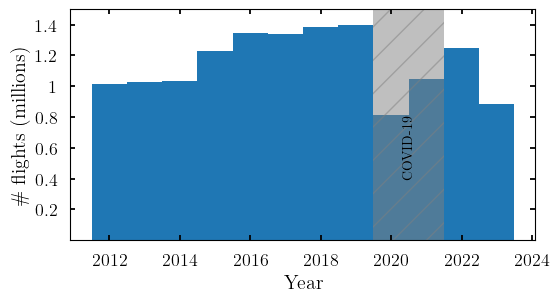

In [7]:
fig=plt.figure(figsize=(6,3))
plt.hist(df["FL_DATE"].dt.year, bins=np.arange(2012-0.5,2024+0.5,1))
ticks = [0.2,0.4,0.6,0.8,1,1.2,1.4]
plt.yticks([x*1e6 for x in ticks], ticks)
plt.ylim([0,1.5e6])
plt.ylabel(r"\# flights (millions)")
plt.xlabel("Year")
plt.axvspan(2019.5,2021.5,color='gray',hatch='/',alpha=0.5,lw=0)
plt.text(2020.5,0.6e6,"COVID-19",ha='center',va='center',rotation=90)
fig.savefig("plots/Nflights_years.png",dpi=500,bbox_inches='tight')
plt.show()

The number of flights increased consistently throughout the 2010's, then dipped after (and during, although we don't have the data) the pandemic. Note that 2023 data is incomplete, this is only the first 8 months.

In [8]:
# df = df[~df["FL_DATE"].dt.year.isin([2020,2021])] # excise pandemic?

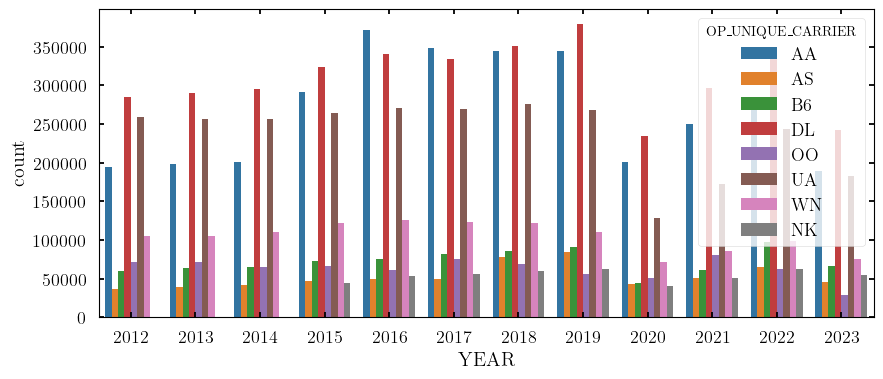

In [11]:
df['YEAR'] = df['FL_DATE'].dt.year
plt.figure(figsize=(10,4))
sns.countplot(df, x="YEAR", hue="OP_UNIQUE_CARRIER")
plt.show()

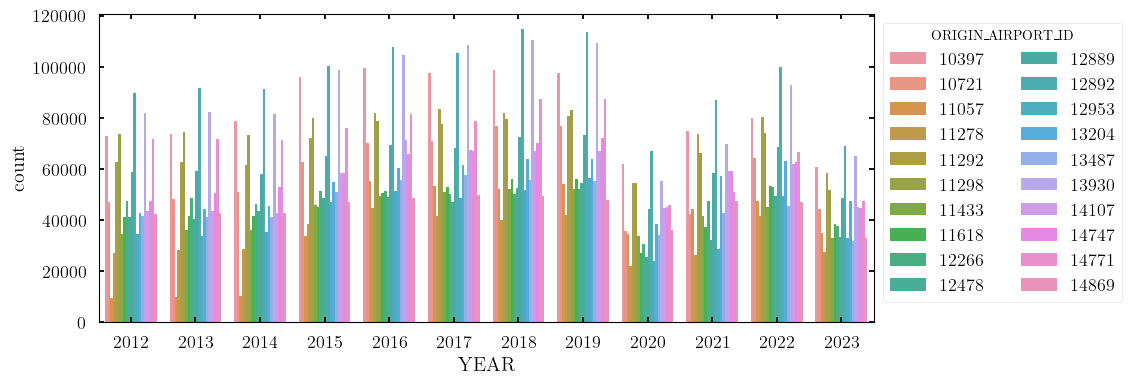

In [12]:
plt.figure(figsize=(10,4))
ax = sns.countplot(df, x="YEAR", hue="ORIGIN_AIRPORT_ID")
sns.move_legend(ax, ncol=2, loc=2, bbox_to_anchor=(1,1))
plt.show()

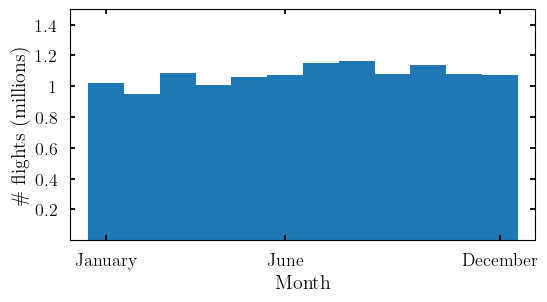

In [13]:
plt.figure(figsize=(6,3))
plt.hist(df[~df["FL_DATE"].dt.year.isin([2023])]["FL_DATE"].dt.month, bins=np.arange(0.5,13.5,1))
plt.yticks([x*1e6 for x in ticks], ticks)
plt.xticks([1,6,12],["January","June","December"])
plt.xlim([0,13])
plt.ylim([0,1.5e6])
plt.ylabel(r"\# flights (millions)")
plt.xlabel(r"Month")

plt.show()
# df.groupby(df["DATE"].dt.month).count().plot(kind="bar")

We can add to that the day-to-day submodulation. Write that as fraction of a year.

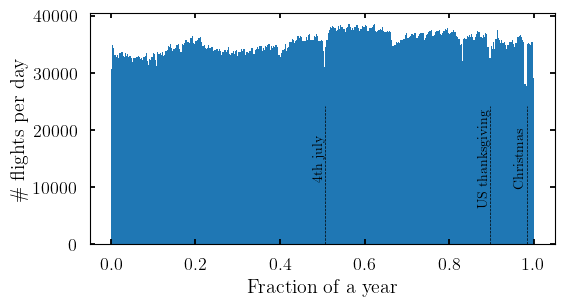

In [15]:
# hist_month()

fig=plt.figure(figsize=(6,3))
plt.hist(df[~df["FL_DATE"].dt.year.isin([2023])]["FRAC_YEAR"],bins=365)

# holidays
for md, name in zip(((7,4),(11,23),(12,25)), ("4th july", "US thanksgiving", "Christmas")):
    m,d = md
    dt = datetime.date(2000,m,d)-datetime.date(2000,1,1)
    frac = dt/pd.to_timedelta(365, unit='D')
    plt.axvline(frac, color='k', ls='--', lw=0.5, ymax=0.6)
    plt.text(frac, 15000, name, ha="right", va="center", rotation=90)

plt.ylabel(r"\# flights per day")
plt.xlabel(r"Fraction of a year")

# Scale to year
# plt.hist(df["FRAC_YEAR"]*12+0.5,bins=365)
# plt.xticks([1,6,12],["January","June","December"])
# plt.axvline()

fig.savefig("plots/Nflights_fracyear.png",dpi=500,bbox_inches='tight')
plt.show()

Looks like we can see holidays in this data!

There is a sharp drop in number of flights at ~0.7. Is that a real end-of-summer effect? Or an artefact of the binning??

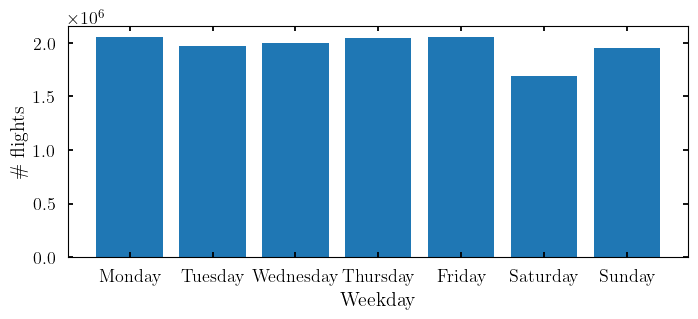

In [16]:
df['weekday'] = df['FL_DATE'].dt.day_name()
weekday_counts = df['weekday'].value_counts()
weekday_counts = weekday_counts.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot the histogram
plt.figure(figsize=(8,3))
plt.bar(weekday_counts.index, weekday_counts.values)
plt.xlabel('Weekday')
plt.ylabel(r"\# flights")
plt.show()

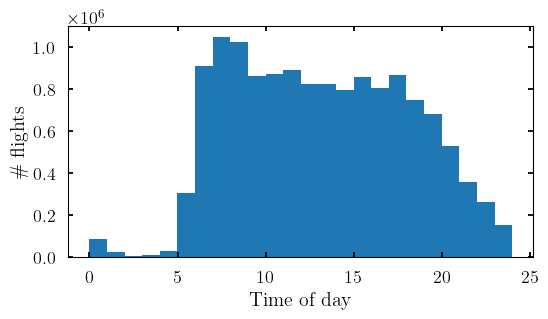

In [17]:
# Number of flights throughout the day. Get frac_day
df['FRAC_DAY'] = (df['FL_DATE'] - df['FL_DATE'].dt.floor('D')) / pd.to_timedelta('1D')
fig=plt.figure(figsize=(6,3))
plt.hist(df['FRAC_DAY']*24, bins=24)
plt.xlabel('Time of day')
plt.ylabel(r"\# flights")
fig.savefig("plots/flights_per_hour.png",dpi=500,bbox_inches='tight')
plt.show()

Now that we have an understanding of when flights happen, we can start looking into delays.

## Delays

If delay is above some threshold (15min), the flight is considered delayed.

In [18]:
delay_thresh=15.
df = df.assign(DELAY_TF=pd.Series(df['DEP_DELAY']>delay_thresh).values.astype(int))

Delayed flights fraction per carrier


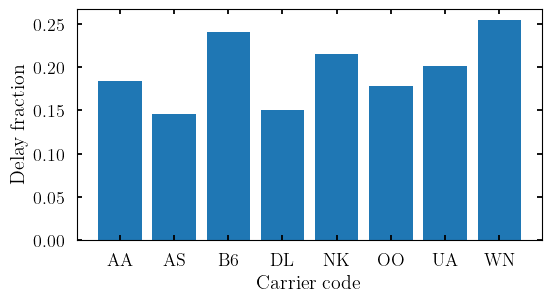

In [21]:
print("Delayed flights fraction per carrier")
carriers=np.unique(df['OP_UNIQUE_CARRIER'])
fracs = []
for carrier in carriers:
    df_car=df.loc[df['OP_UNIQUE_CARRIER']==carrier]
    frac = len(df_car.loc[df_car['DELAY_TF']==1])/len(df_car)
#     print(f"{carrier}: {frac:.2f}")
    fracs.append(frac)
    
fig = plt.figure(figsize=(6,3))
plt.ylabel("Delay fraction")
plt.xlabel("Carrier code")
plt.bar(carriers, fracs)
fig.savefig("plots/delay_frac_carrier.png",dpi=500,bbox_inches='tight')
plt.show()

Carrier seems to matter. In particular, WN (SouthWest) has many late flights, AS (Alaska) has few.

In [22]:
# Another way to see this, but it's not normalized so not as clear
# sns.countplot(df, x="OP_UNIQUE_CARRIER", hue="DELAY_TF")

In [23]:
# Did any carrier get worse over time?
years = np.sort(df["FL_DATE"].dt.year.unique())
fracs = np.zeros((len(carriers), len(years)))
for i in range(len(carriers)):
    for j in range(len(years)):
        df_at = df.loc[(df['OP_UNIQUE_CARRIER']==carriers[i]) & (df['FL_DATE'].dt.year==years[j])]
        if len(df_at)>0:
            fracs[i,j] = len(df_at.loc[df['DELAY_TF']==1])/len(df_at)

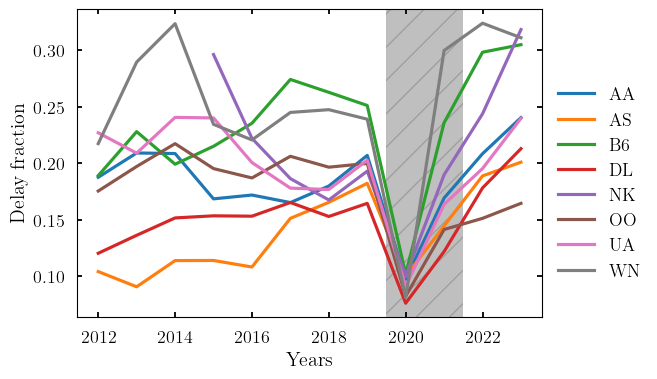

In [24]:
fig=plt.figure(figsize=(6,4))
plt.xlabel('Years')
plt.ylabel('Delay fraction')
for i in range(len(fracs)):
    if carriers[i]=='NK':
        plt.plot(years[3:], fracs[i][3:], label=carriers[i])
    else:
        plt.plot(years, fracs[i], label=carriers[i])
plt.axvspan(2019.5,2021.5,color='gray',hatch='/',alpha=0.5,lw=0)
# plt.text(2020.5,0.6e6,"COVID-19",ha='center',va='center',rotation=90)
plt.legend(bbox_to_anchor=(1,0.8),frameon=False)
fig.savefig("plots/delay_frac_carrier_over_time.png",dpi=500,bbox_inches='tight')
plt.show()

Some carriers got worse over time, especially B6 (JetBlue) and WN (SouthWest) post-pandemic.

air time 0.00 - 30.95 : 0.25 +/- 0.04. (N=460)
air time 30.95 - 61.89 : 0.19 +/- 0.00. (N=1720806)
air time 61.89 - 92.84 : 0.18 +/- 0.00. (N=2128499)
air time 92.84 - 123.79 : 0.20 +/- 0.00. (N=2671846)
air time 123.79 - 154.74 : 0.18 +/- 0.00. (N=2194196)
air time 154.74 - 185.68 : 0.18 +/- 0.00. (N=1245321)
air time 185.68 - 216.63 : 0.18 +/- 0.00. (N=1156484)
air time 216.63 - 247.58 : 0.19 +/- 0.00. (N=891864)
air time 247.58 - 278.53 : 0.19 +/- 0.00. (N=613960)
air time 278.53 - 309.47 : 0.19 +/- 0.00. (N=582516)
air time 309.47 - 340.42 : 0.19 +/- 0.00. (N=346264)
air time 340.42 - 371.37 : 0.18 +/- 0.00. (N=180770)
air time 371.37 - 402.32 : 0.19 +/- 0.00. (N=29815)
air time 402.32 - 433.26 : 0.24 +/- 0.02. (N=1890)
air time 433.26 - 464.21 : 0.29 +/- 0.17. (N=28)
air time 464.21 - 495.16 : 0.00 +/- 0.00. (N=1)


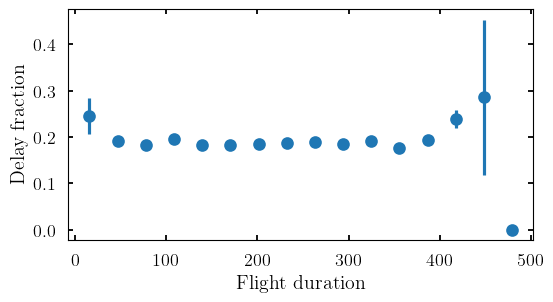

In [25]:
# late fraction depending on airtime 
# bins=np.linspace(np.min(df['AIR_TIME']),np.max(df['AIR_TIME']),20)
bins=np.linspace(0,np.max(df['AIR_TIME']),20)

medbins,fracs,CIs=[],[],[]
count_=1

# Consider the 95% confidence interval
# https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval
z = 1.96

for el in bins:
    if count_<len(bins):
        df_at = df.loc[(df['AIR_TIME']>el)&(df['AIR_TIME']<bins[count_])]
        N = len(df_at)
        if N>0:
            p = len(df_at.loc[df_at['DELAY_TF']==1])/N
            CI = z * np.sqrt(p*(1-p)/N)
            print(f"air time {el:.2f} - {bins[count_]:.2f} : {p:.2f} +/- {CI:.2f}. (N={N})")

            CIs.append(CI)
            medbins.append(0.5*(el+bins[count_]))
            fracs.append(p)
    count_+=1

fig = plt.figure(figsize=(6,3))
# plt.scatter(medbins,fracs)
plt.errorbar(medbins,fracs,CIs,linestyle='none',marker='o',capsize=3)
plt.xlabel("Flight duration")
plt.ylabel("Delay fraction")
fig.savefig("plots/delay_frac_airtime.png",dpi=500,bbox_inches='tight')
plt.show()

There is some interesting modulation with flight duration

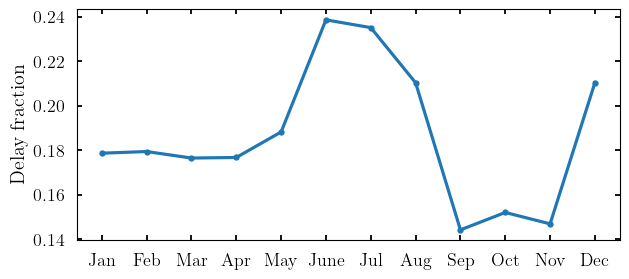

In [26]:
bins=np.linspace(0,1,13)
medbins,fracs=[],[]
count_=1

for el in bins:
    if count_<len(bins):
        df_at=df.loc[(df['FRAC_YEAR']>el)&(df['FRAC_YEAR']<bins[count_])]
        N = len(df_at)
        p = len(df_at.loc[df_at['DELAY_TF']==1])/N
        medbins.append(0.5*(el+bins[count_]))
        fracs.append(p)
    count_+=1

fig=plt.figure(figsize=(7,3))
plt.plot(medbins,fracs,'.-')
# plt.xlabel("Fraction year")
plt.xticks(medbins, ["Jan","Feb","Mar","Apr","May","June","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.ylabel("Delay fraction")
fig.savefig("plots/delay_frac_year_frac.png",dpi=500,bbox_inches='tight')
plt.show()

Delays peak in the summer and in december, and are much less frequent in the fall.

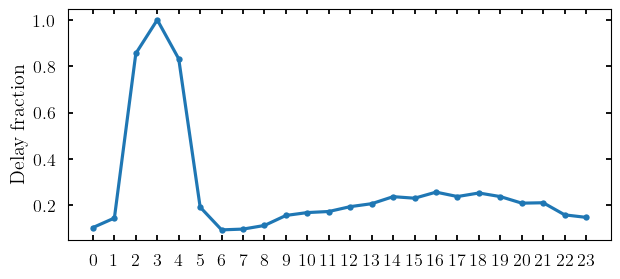

In [27]:
bins=np.linspace(0,1,25)
medbins,fracs=[],[]
count_=1

for el in bins:
    if count_<len(bins):
        df_at=df.loc[(df['FRAC_DAY']>el)&(df['FRAC_DAY']<bins[count_])]
        N = len(df_at)
        p = len(df_at.loc[df_at['DELAY_TF']==1])/N
        medbins.append(0.5*(el+bins[count_]))
        fracs.append(p)
    count_+=1

fig=plt.figure(figsize=(7,3))
plt.plot(medbins,fracs,'.-')
# plt.xlabel("Fraction day")
plt.xticks(medbins, np.arange(0,24,1))
plt.ylabel("Delay fraction")
fig.savefig("plots/delay_frac_year_frac.png",dpi=500,bbox_inches='tight')
plt.show()

Delays peak at night!

In [28]:
airports = pd.read_csv("../data/AIRPORT_ID.csv")
airports.info()

airports_dict = airports.set_index('Code').to_dict()['Description']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6659 entries, 0 to 6658
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Code         6659 non-null   int64 
 1   Description  6659 non-null   object
dtypes: int64(1), object(1)
memory usage: 104.2+ KB


In [29]:
# sorted counts of flights per airport
ap_counts = df['ORIGIN_AIRPORT_ID'].value_counts().to_dict()

print("Top airports")
for ap in ap_counts.keys():
    print(airports_dict[ap], " : ", ap_counts[ap])

Top airports
Los Angeles, CA: Los Angeles International  :  1137574
Chicago, IL: Chicago O'Hare International  :  1060540
Atlanta, GA: Hartsfield-Jackson Atlanta International  :  992252
Dallas/Fort Worth, TX: Dallas/Fort Worth International  :  867851
Denver, CO: Denver International  :  853931
San Francisco, CA: San Francisco International  :  837059
Las Vegas, NV: Harry Reid International  :  744708
Seattle, WA: Seattle/Tacoma International  :  696603
Boston, MA: Logan International  :  691297
Phoenix, AZ: Phoenix Sky Harbor International  :  672668
Orlando, FL: Orlando International  :  643395
Houston, TX: George Bush Intercontinental/Houston  :  566065
Minneapolis, MN: Minneapolis-St Paul International  :  554155
Newark, NJ: Newark Liberty International  :  541142
Salt Lake City, UT: Salt Lake City International  :  534681
New York, NY: John F. Kennedy International  :  517739
Detroit, MI: Detroit Metro Wayne County  :  511238
New York, NY: LaGuardia  :  493620
Charlotte, NC: Char

In [30]:
frac = []
origins = df['ORIGIN_AIRPORT_ID'].unique()
for orig in origins:
    df_at = df.loc[df['ORIGIN_AIRPORT_ID'] == orig]
    frac.append(len(df_at.loc[df['DELAY_TF']==1])/len(df_at))

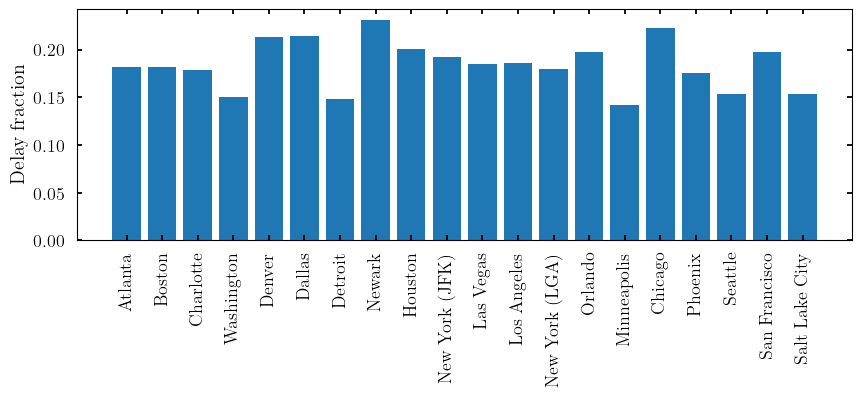

In [31]:
fig=plt.figure(figsize=(10,3))
names = []
for o in origins: 
    name = airports_dict[o].split('/')[0].split(',')[0]
    if o==12478:
        name += " (JFK)"
    if o==12953:
        name += " (LGA)"
    names.append(name)
    
plt.bar(names, frac)
plt.ylabel("Delay fraction")
plt.xticks(rotation=90)
fig.savefig("plots/delay_frac_airport.png",dpi=500,bbox_inches='tight')
plt.show()

In [32]:
# Worse over time?
fracs = np.zeros((len(origins), len(years)))
for i in range(len(origins)):
    for j in range(len(years)):
        df_at = df.loc[(df['ORIGIN_AIRPORT_ID']==origins[i]) & (df['FL_DATE'].dt.year==years[j])]
        if len(df_at)>0:
            fracs[i,j] = len(df_at.loc[df['DELAY_TF']==1])/len(df_at)

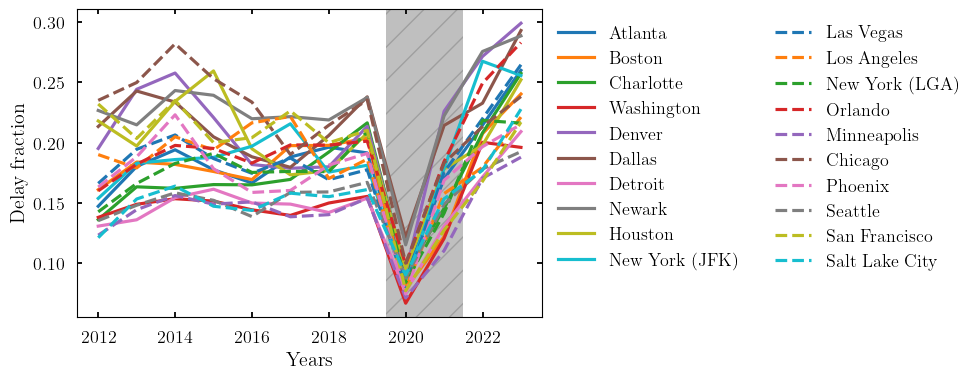

In [36]:
fig=plt.figure(figsize=(6,4))
plt.xlabel('Years')
plt.ylabel('Delay fraction')
for i in range(len(fracs)):
    ls = '-' if i<10 else '--'
    plt.plot(years, fracs[i], label=names[i], ls=ls)
plt.axvspan(2019.5,2021.5,color='gray',hatch='/',alpha=0.5,lw=0)
plt.legend(bbox_to_anchor=(1,1), ncol=2, frameon=False)
fig.savefig("plots/delay_frac_airport_over_time.png",dpi=500,bbox_inches='tight')
plt.show()

Denver, Dallas, Newark and Orlando have gotten really bad post-pandemic!!

# Other stuff
### If the flight is delayed, by how much?

(0.0, 200.0)

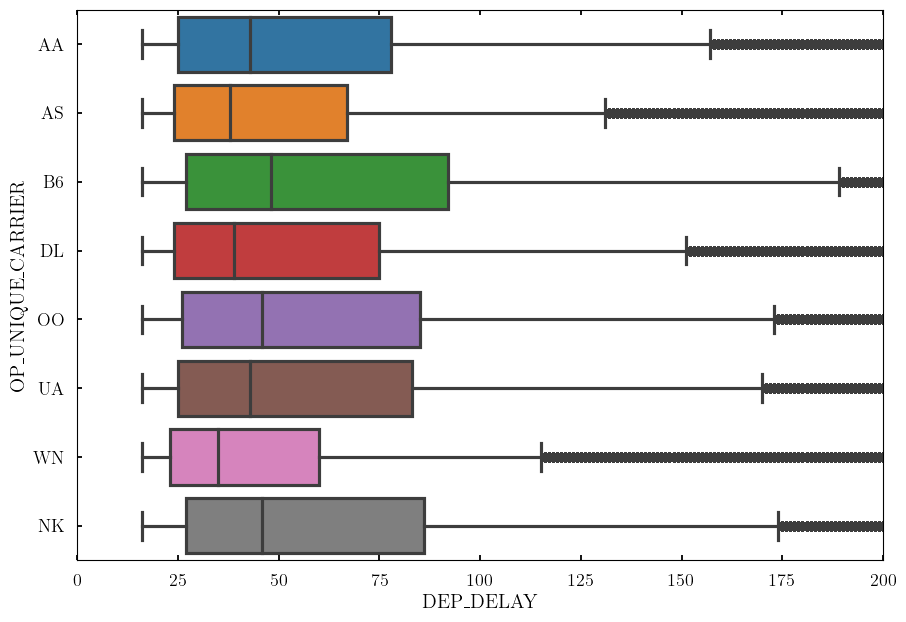

In [37]:
fig, ax = plt.subplots()
sns.boxplot(data=df.loc[df['DELAY_TF']==1], x="DEP_DELAY", y="OP_UNIQUE_CARRIER", ax=ax)
ax.set_xlim([0,200])

/Users/simon/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


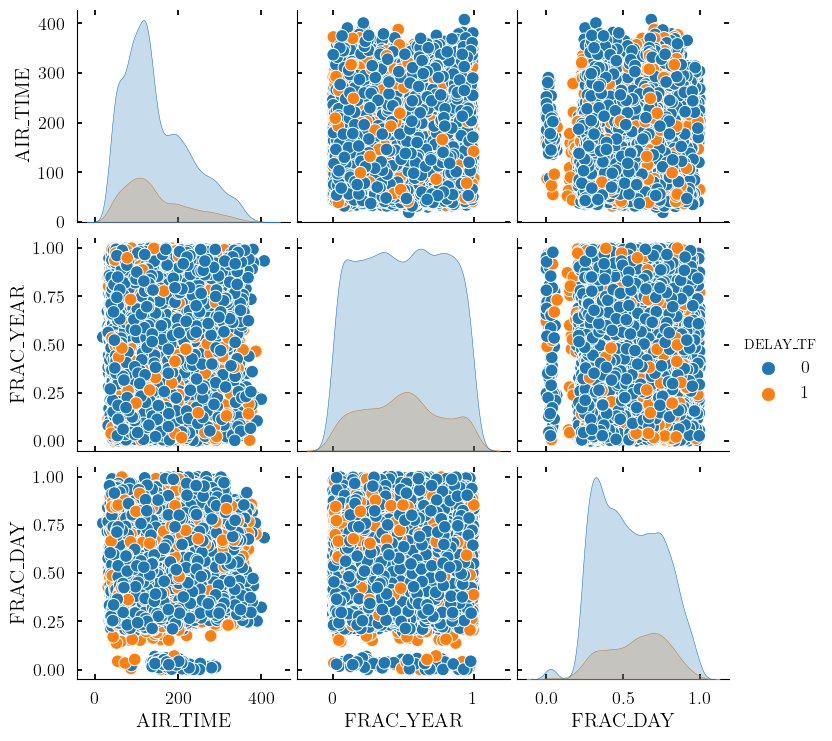

In [38]:
# Seaborn pairplot

small_df = df.sample(10000)
small_df = pd.get_dummies(small_df, 
                          columns=['OP_UNIQUE_CARRIER','ORIGIN_AIRPORT_ID'], 
                          drop_first=True, dtype=int)

# columns = ['AIR_TIME','FRAC_YEAR','OP_UNIQUE_CARRIER_WN','OP_UNIQUE_CARRIER_DL']

columns = ['AIR_TIME','FRAC_YEAR','FRAC_DAY']

# sns.pairplot(data = df.loc[df['FL_DATE'].dt.year==2022], x_vars=columns, y_vars=columns, hue='DELAY_TF')
sns.pairplot(data = small_df, x_vars=columns, y_vars=columns, hue='DELAY_TF')
plt.show()